In [9]:
import numpy as np
import math
import os
import random
import queue
import matplotlib.pyplot as pl

In [10]:
NP=6
PAGE_SIZE=4096

In [11]:
def init_proc_queue():
    pq=queue.Queue(maxsize=NP)
    proc_queue=list(set((NP*np.random.random(20)).astype('int32')))
    random.shuffle(proc_queue)
    for pr in proc_queue:
        pq.put_nowait(pr)
        
    print(proc_queue)
init_proc_queue()

[4, 3, 2, 1, 0, 5]


In [12]:
def correct_refs(alist,cent,maxpg):
    if cent!=0:
        pgnum=int(cent/PAGE_SIZE)
        lh=(pgnum+1)*PAGE_SIZE-1
        ll=pgnum*PAGE_SIZE
    else:
        lh=maxpg*PAGE_SIZE
        ll=0
        
    for i in range(alist.shape[0]):
        if alist[i]>=lh:
            alist[i]=lh-1
        if alist[i]<ll:
            alist[i]=ll+1
    return alist

def sim_process(M,sigma,outfile,lfrac=0.9):
    cur_page=int(M*np.random.random()) #Generating random start page
    cur_locale=round(PAGE_SIZE*(cur_page+0.5)) #Generating location of current page
    sum_refs=0
    list_locales=list()
    for count in range(M):
        num_refs=int(512+(PAGE_SIZE-512)*np.random.random())
        sum_refs+=num_refs
        list_locales.append(cur_page)
        num_loc=round(lfrac*num_refs)
        aref_list=np.random.normal(cur_locale,sigma*300+100,num_loc)
#         aref_list=correct_refs(aref_list,cur_locale,M)
        aref_list=aref_list.astype('int32')
        cur_page=int(M*np.random.random())
        cur_locale=round(PAGE_SIZE*(cur_page+0.5))
        num_trans=round((1-lfrac)*num_refs)
        tref_list=np.random.random(num_trans)*cur_locale
#         tref_list=correct_refs(tref_list,0,M)
        tref_list=tref_list.astype('int32')
        np.append(aref_list,tref_list).tofile(outfile,sep='\n')
        outfile.write('\n')
    return list_locales,sum_refs
        
      
    print('Current Page',cur_page)
    print('Current Location',cur_locale)
    print('List of Locations',list_locales)
    
npg = int(np.random.normal(10,2.5))
nsig = int(5 * np.random.random())    
fname = 'AR_' + '{:02d}'.format(0) + '.txt'
fname=open(fname,'w')
sim_process(npg,nsig,fname)

([0, 0], 7722)

In [13]:
int(512+(PAGE_SIZE-512)*np.random.random())

3073

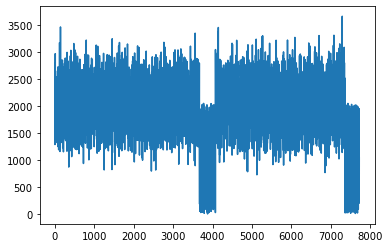

In [14]:
file=np.loadtxt('AR_00.txt')
pl.plot(file)

In [15]:
pr_size=np.zeros(NP,dtype='int32')

for p in range(NP):
    fname='AR_'+'{:02d}'.format(p)+'.txt'
    op=open(fname,'w')
    npg=int(np.random.normal(10,2.5))
    nsig=int(5*np.random.random())
    print(f'Process {p} requires {npg} pages and has a quality {nsig}')
    pg_seq,pr_size[p]=sim_process(npg,nsig,op)
    print(pg_seq,pr_size[p])
    op.write('\n')
    op.close()
    print('written process',p,'to ',fname)

Process 0 requires 11 pages and has a quality 3
[5, 2, 1, 7, 4, 8, 10, 1, 0, 3, 6] 31393
written process 0 to  AR_00.txt
Process 1 requires 8 pages and has a quality 0
[2, 6, 4, 5, 5, 6, 0, 6] 24626
written process 1 to  AR_01.txt
Process 2 requires 12 pages and has a quality 1
[3, 9, 4, 1, 1, 6, 2, 3, 5, 4, 7, 11] 31637
written process 2 to  AR_02.txt
Process 3 requires 8 pages and has a quality 3
[6, 3, 5, 0, 5, 2, 4, 1] 17763
written process 3 to  AR_03.txt
Process 4 requires 8 pages and has a quality 4
[1, 6, 5, 6, 7, 7, 6, 6] 21930
written process 4 to  AR_04.txt
Process 5 requires 8 pages and has a quality 2
[6, 3, 7, 2, 2, 3, 6, 4] 21931
written process 5 to  AR_05.txt


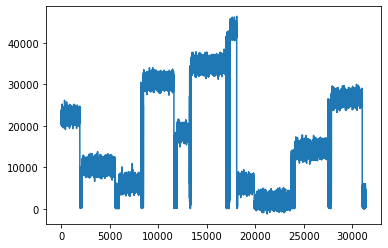

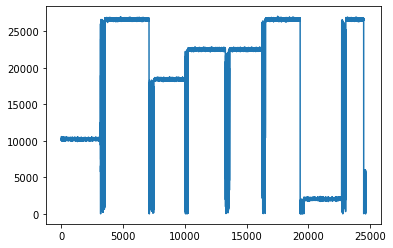

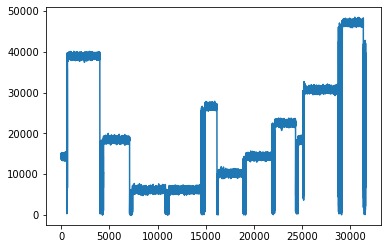

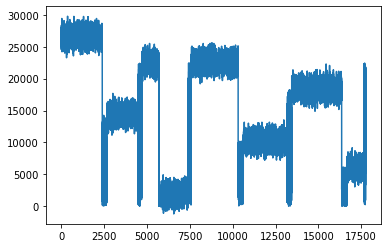

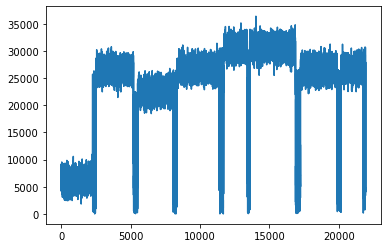

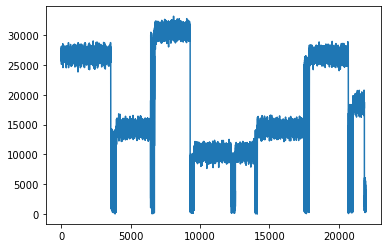

In [16]:
for p in range(NP):
    fname='AR_'+'{:02d}'.format(p)+'.txt'
    temp=np.loadtxt(fname)
    pl.plot(temp)
    pl.show()